Zbieżność osiągnięta w iteracji: 3763
107.11469037967674 107.11479723422903


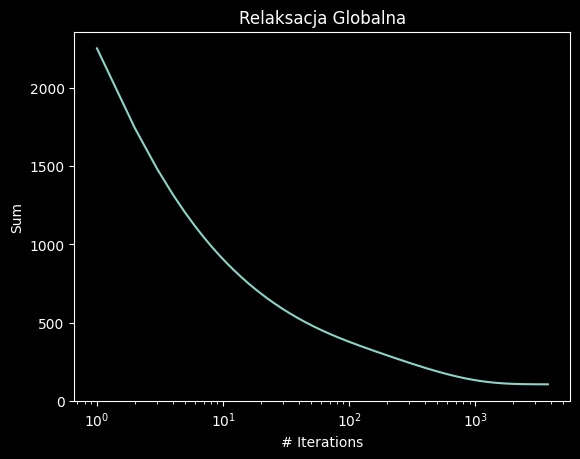

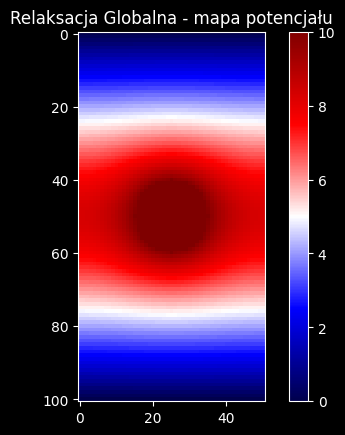

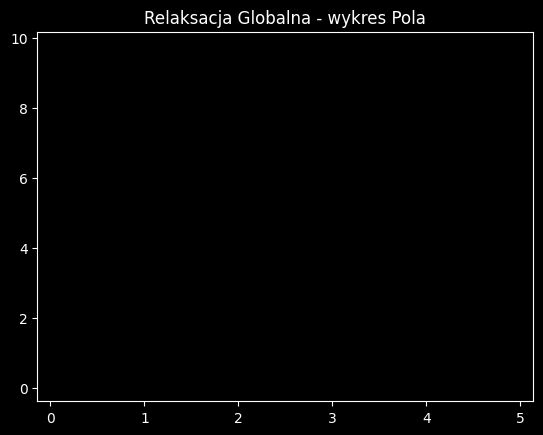

Zbieżność osiągnięta w iteracji: 2033
107.09440669214707 107.09451330205853
Zbieżność osiągnięta w iteracji: 2033
107.09440669214707 107.09451330205853


ValueError: x and y must have same first dimension, but have shapes (1,) and (2033,)

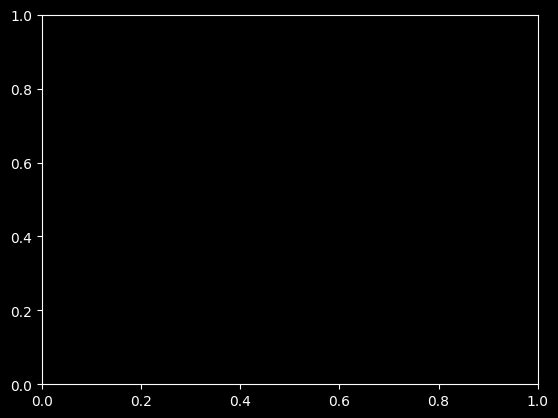

In [2]:
import numpy as np
import matplotlib.pyplot as plt

PARAMS = {
    'Nx': 50,
    'Ny': 100,
    'dx': 0.1,
    'Vc': 10.0,
    'Rc': 1.0,
    'epsilon': 1e-6,
}

V = np.zeros((PARAMS['Nx']+1, PARAMS['Ny']+1))

# Ustawienie potencjału nanoruki bazując na warunkach brzegowych

# WB Dirichleta w okręgu
ic, jc = (PARAMS['Nx']//2, PARAMS['Ny']//2)
i_coords, j_coords = np.meshgrid(np.arange(PARAMS['Nx'] + 1), np.arange(PARAMS['Ny'] + 1), indexing='ij')

R_grid = PARAMS['Rc'] / PARAMS['dx']
distance_squared = (i_coords - ic)**2 + (j_coords - jc)**2
nanotube_mask = distance_squared <= R_grid**2
V[nanotube_mask] = PARAMS['Vc']

#WB Neumana (Potencjał na granicy równy potencjałowi sąsiedniemu)
def apply_neumann_wb(V_grid):
    global PARAMS

    # Lewa krawędź
    V_grid[0, 1:PARAMS['Ny']] = V_grid[1, 1:PARAMS['Ny']]
    # Prawa krawędź
    V_grid[PARAMS['Nx'], 1:PARAMS['Ny']] = V_grid[PARAMS['Nx'] - 1, 1:PARAMS['Ny']]

    return V_grid


#========= DEBUG =========#
# print(V.shape)
# plt.imshow(V)
# plt.show()

def calculate_S(V_grid, dx):

    #Suma
    V_i_j = V_grid[:-1, :-1]
    V_i_plus_1_j = V_grid[1:, :-1]
    V_i_j_plus_1 = V_grid[:-1, 1:]

    numerator_x = V_i_plus_1_j - V_i_j          #Błąd w skrypcie poinno być V_i+1,j - V_i,j -> wynika z klasycznej definicji pochodnej (5)
    term_x_squared = (numerator_x / dx)**2

    numerator_y = V_i_j_plus_1 - V_i_j
    term_y_squared = (numerator_y / dx)**2

    pre_factor = (dx**2) / 2
    S = pre_factor * np.sum(term_x_squared + term_y_squared)

    return S

def global_relaxation():
    global PARAMS, nanotube_mask, i_coords, j_coords

    V_s = np.zeros((PARAMS['Nx'] + 1, PARAMS['Ny'] + 1))
    # Ustawienie początkowych WB Dirichleta
    V_s[:, 0] = 0.0
    V_s[:, PARAMS['Ny']] = 0.0
    V_s[nanotube_mask] = PARAMS['Vc']

    V_n = V_s.copy()

    S_values = []
    Iter_num = []

    for iteration in range(1, 50000): # Limit iteracji


        # Krok 1: Obliczanie V_n (tylko wewnątrz, poza brzegami i nanorurką)
        # Tworzymy maskę dla węzłów, które mają być obliczone
        internal_mask = np.ones((PARAMS['Nx'] + 1, PARAMS['Ny'] + 1), dtype=bool)
        internal_mask[0, :] = False; internal_mask[PARAMS['Nx'], :] = False
        internal_mask[:, 0] = False; internal_mask[:, PARAMS['Ny']] = False
        internal_mask[nanotube_mask] = False

        # Wzór (7) - uśrednianie 4 sąsiadów
        V_n[internal_mask] = 0.25 * (
            V_s[i_coords[internal_mask] + 1, j_coords[internal_mask]] +
            V_s[i_coords[internal_mask] - 1, j_coords[internal_mask]] +
            V_s[i_coords[internal_mask], j_coords[internal_mask] + 1] +
            V_s[i_coords[internal_mask], j_coords[internal_mask] - 1]
        )

        # Krok 2: Uwzględnienie WB Neumanna w V_n (przy i=0 i i=Nx)
        V_n = apply_neumann_wb(V_n)



        # Obliczanie S
        S_it = calculate_S(V_n, PARAMS['dx'])
        S_values.append(S_it)
        Iter_num.append(iteration)

        # Sprawdzanie zbieżności
        if iteration > 1:
            S_prev = S_values[-2]
            if S_prev != 0 and np.abs((S_it - S_prev) / S_prev) < PARAMS['epsilon']:
                print(f"Zbieżność osiągnięta w iteracji: {iteration}")
                print(S_it, S_prev)
                break
        # Krok 3: Przepisanie tablicy
        V_s = V_n.copy()

        #Debug print
        # plt.imshow(V_n)
        # plt.show()

    return V_n, S_values, Iter_num

# Uruchomienie Zadania 1
V_global, S_global, Iter = global_relaxation()
plt.plot(Iter, S_global)
plt.title("Relaksacja Globalna")
plt.xlabel("# Iterations")
plt.ylabel("Sum")
plt.xscale('log')
plt.show()

# Zadanie 2: Wykres mapy potencjału V
plt.imshow(V_global.T, cmap='seismic')
plt.title("Relaksacja Globalna - mapa potencjału")
plt.colorbar()
plt.show()

# Zadanie 3: Wykres Pola
Ex = -(V_global[2:, 1:-1] - V_global[:-2, 1:-1])/(2*PARAMS['dx'])
Ey = -(V_global[1:-1, 2:] - V_global[1:-1, :-2])/(2*PARAMS['dx'])


# Siatka
M, N = V_global.shape




# 1. Tworzenie pełnej siatki
x_full = np.linspace(0, (M-1) * PARAMS['dx'], M)
y_full = np.linspace(0, (N-1) * PARAMS['dx'], N)

# 2. Tworzenie siatki 2D
X, Y = np.meshgrid(x_full, y_full, indexing='ij')

# --- Dostosowanie X i Y do wymiarów Ex i Ey ---
x = X[1:-1, 1:-1]
y = Y[1:-1, 1:-1]



arrow_step = 4 # Wiekszy znaczy mniej
plt.quiver(x[::arrow_step, ::arrow_step], y[::arrow_step, ::arrow_step], Ex[::arrow_step , ::arrow_step], Ey[::arrow_step , ::arrow_step], scale =50, headwidth =10)
plt.title("Relaksacja Globalna - wykres Pola")
plt.show()


def local_relaxation(omega):
    global PARAMS, nanotube_mask, i_coords, j_coords


    V = np.zeros((PARAMS['Nx'] + 1, PARAMS['Ny'] + 1))

    V[:, 0] = 0.0
    V[:, PARAMS['Ny']] = 0.0
    V[nanotube_mask] = PARAMS['Vc']

    S_values = []
    Iter_num = []

    # Utworzenie maski dla węzłów, które mają być obliczone (Węzły wewnętrzne)
    internal_mask = np.ones((PARAMS['Nx'] + 1, PARAMS['Ny'] + 1), dtype=bool)
    internal_mask[0, :] = False; internal_mask[PARAMS['Nx'], :] = False
    internal_mask[:, 0] = False; internal_mask[:, PARAMS['Ny']] = False
    internal_mask[nanotube_mask] = False

    internal_i_coords = i_coords[internal_mask]
    internal_j_coords = j_coords[internal_mask]

    for iteration in range(1, 50000):

        # Krok 1: Modyfikacja elementów w JEDNEJ tablicy V (iteracja węzeł po węźle)
        for i, j in zip(internal_i_coords, internal_j_coords):
            # Wzór (9) w postaci wektoryzacji (bliżej metody Jacobiego z relaksacją):
            V_new_ij = (
                V[i + 1, j] +
                V[i - 1, j] +
                V[i, j + 1] +
                V[i, j - 1]
            )
            V[i, j] = (1 - omega) * V[i, j] + (omega/4) * V_new_ij


        # Krok 2: Uwzględnienie WB Neumanna w V (przy i=0 i i=Nx)
        V = apply_neumann_wb(V) # Nadpisanie V z uwzględnionymi WB Neumanna

        # Obliczanie S
        S_it = calculate_S(V, PARAMS['dx'])
        S_values.append(S_it)
        Iter_num.append(iteration)

        # Sprawdzanie zbieżności
        if iteration > 1:
            S_prev = S_values[-2]
            if S_prev != 0 and np.abs((S_it - S_prev) / S_prev) < PARAMS['epsilon']:
                print(f"Zbieżność osiągnięta w iteracji: {iteration}")
                print(S_it, S_prev)
                break

    return V, S_values, Iter_num



# zadanie 4 i 5
V_local, S_local, Iter_L = local_relaxation(omega=1.0)

omegas = [1, 1.4, 1.8, 1.9]
for o in omegas:
    V_local, S_local, Iter_L = local_relaxation(omega=o)
    plt.plot(Iter_L, S_local, label=f'w = {o} iter: {Iter_L[-1]}')


# Wykresy
plt.title("Relaksacja Lokalna")
plt.xlabel("# Iterations")
plt.ylabel("Sum")
plt.xscale('log')
plt.legend()
plt.show()

# mapa potencjału
plt.imshow(V_local.T, cmap='seismic')
plt.colorbar()
plt.title(f"Relaksacja Lokalna - mapa potencjału w={omegas[-1]}")
plt.show()



# mapa wektorowa pola
Ex = -(V_local[2:, 1:-1] - V_local[:-2, 1:-1])/(2*PARAMS['dx'])
Ey = -(V_local[1:-1, 2:] - V_local[1:-1, :-2])/(2*PARAMS['dx'])


# Siatka
M, N = V_local.shape

# 1. Tworzenie pełnej siatki
x_full = np.linspace(0, (M-1) * PARAMS['dx'], M)
y_full = np.linspace(0, (N-1) * PARAMS['dx'], N)

# 2. Tworzenie siatki 2D
X, Y = np.meshgrid(x_full, y_full, indexing='ij')

# --- Dostosowanie X i Y do wymiarów Ex i Ey ---
x = X[1:-1, 1:-1]
y = Y[1:-1, 1:-1]



arrow_step = 4 # Wiekszy znaczy mniej
plt.quiver(x[::arrow_step, ::arrow_step], y[::arrow_step, ::arrow_step], Ex[::arrow_step , ::arrow_step], Ey[::arrow_step , ::arrow_step], scale =50, headwidth =10)
plt.title(f"Relaksacja Lokalna - pole w={omegas[-1]}")
plt.show()
